[View in Colaboratory](https://colab.research.google.com/github/nfmorenog/Sistemas-inteligentes/blob/master/iis_practica1_nfmorenog_menoguerar.ipynb)

# Práctica 1
# Clasificación Lineal y Evaluación del Desempeño
## [Introducción a los Sistemas Inteligentes](https://fagonzalezo.github.io/iis-2018-2/)
### Presentado por:
### Nelson Felipe Moreno Gómez y Marlon Enrique Noguera Ramirez



En esta práctica vamos a construir un clasificador lineal para clasificar tipos de vinos. Para esto vamos a  descargar la base de datos llamada *Wine* disponible en [aquí](https://drive.google.com/open?id=0B8POkZpAJ5qQRlFzVUZnMlZVakk). Si requiere más información sobre la base datos, la puede encontrar en el siguiente link  [aquí](https://archive.ics.uci.edu/ml/datasets/wine).

El conjunto de datos contiene los ejemplos de 178 vinos. Cada uno identificado por 13 propiedades químicas:
* Alcohol
* Malic_acid
* Ash
* Alcalinity
* Magnesium
* Phenols
* Flavanoids
* Nonflavanoid
* Proanthocyanins
* Color
* Hue
* OD280/OD315
* Proline

A cada vino le fue asignada una clase, que corresponde al tipo de vino $[1, 2, 3]$

1. Cargue el conjunto de datos como un DataFrame de Pandas
2. Cargue la clase en un arreglo aparte. Eliminela del DataFrame de Pandas
3. Genere un histograma para cada propiedad del conjunto de datos
4. Use `scatter_matrix` y visualize todas las posibles combinaciones de características
    * ¿Encuentra algún par de características en el que se observan las clases bien separadas?

**Clasificación usando solo dos características y el esquema Multinomial:**
5. Entrene un modelo LogisticRegression para categorizar el tipo de vino usando `Proline` contra `Flavonoids`.
6. Entrene otro modelo LogisticRegression para categorizar el tipo de vino usando `Alcalinity` contra `Malic Acid`.
7. Imprima la región de decisión de cada clasificador.
8. Genere la matriz de confusión de cada clasificador.
9. Reporte el accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro.
    * ¿Cual modelo se desempeña mejor? ¿Por qué?

**Clasificación usando todas las características:**
10. Entrene un modelo LogisticRegression usando el esquema "*One vs All*".
11. Entrene un modelo LogisticRegression usando el esquema multinomial.
12  Genere la matriz de confusión de cada clasificador.
13  Reporte el accuracy, el error de clasificación, la precisión por clase, el recall por clase y el F1 score por clase.
  * ¿Cual modelo se desempeña mejor? ¿Por qué? ¿Cual clase es más sencilla para el clasificador?

#### Importamos las librerias principales a usar en el notebook ####

In [1]:
#Instalación del paquete tabulate para imprimir la matriz de confusión
!pip install tabulate

    100% |████████████████████████████████| 51kB 1.9MB/s 
  Running setup.py bdist_wheel for tabulate ... - done
  Stored in directory: /root/.cache/pip/wheels/2a/85/33/2f6da85d5f10614cbe5a625eab3b3aebfdf43e7b857f25f829
Successfully built tabulate


In [0]:
%matplotlib inline
import numpy as np
import pylab as pl
import seaborn as sns; sns.set()
from sklearn import preprocessing
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

#### Definimos las funciones a utilizar en el notebook####

In [0]:
def plot_data(X, y):   #Función para graficar datos (X,y)
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region2(X, pred_fun):      #Función para visualizar la superficie de decisión de nuestro algoritmo.
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 1, vmax=3)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def list_cm(cm, classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
      cm.astype(int)
      row_0 =['','Valor','Verdadero']
      row_1 =['-',classes[0],classes[1]]
      row_2 =[classes[0],cm[0,0],cm[1,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1]]
      table = zip(row_0,row_1, row_2, row_3)
      headers = ['', '', 'Valor', 'Predicho']  
      return print(tabulate(table, headers=headers, floatfmt=".0f"))
    else:
      cm.astype(int)
      row_0 =['','Valor','Verdadero','']
      row_1 =['-',np.int(classes[0]),classes[1],classes[2]]
      row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
      row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
      table = zip(row_0,row_1, row_2, row_3, row_4)
      headers = ['', '', 'Valor', 'Predicho', '']  
      return print(tabulate(table, headers=headers, floatfmt=".0f")) 

### 1. Cargamos el conjunto de datos como un DataFrame de Pandas ###

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Autenticación y creación del cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'11pvH069hKkdzFC0HYQQ6v0fwAjzdYEd5' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [0]:
train_downloaded = drive.CreateFile({'id': '11pvH069hKkdzFC0HYQQ6v0fwAjzdYEd5'})
train_downloaded.GetContentFile('wine.data.txt')

In [9]:
import pandas as pd
from pandas.plotting import scatter_matrix
wine_df = pd.read_csv('wine.data.txt')
wine_df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [0]:
data_matrix=wine_df.values

### 2. Cargamos la clase en un arreglo aparte y la eliminamos del DataFrame de Pandas###

In [0]:
class_array=wine_df["Class"]
wine_df1= wine_df.drop(columns=["Class"])

In [12]:
wine_df.columns

Index(['Class', 'Alcohol', ' Malic_acid', ' Ash', ' Alcalinity', ' Magnesium',
       ' Phenols', ' Flavanoids', ' Nonflavanoid', ' Proanthocyanins', 'Color',
       ' Hue', ' OD280/OD315', ' Proline    '],
      dtype='object')

### 3. Generamos un histograma para cada propiedad del conjunto de datos###

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff86f3930f0>,
      dtype=object)

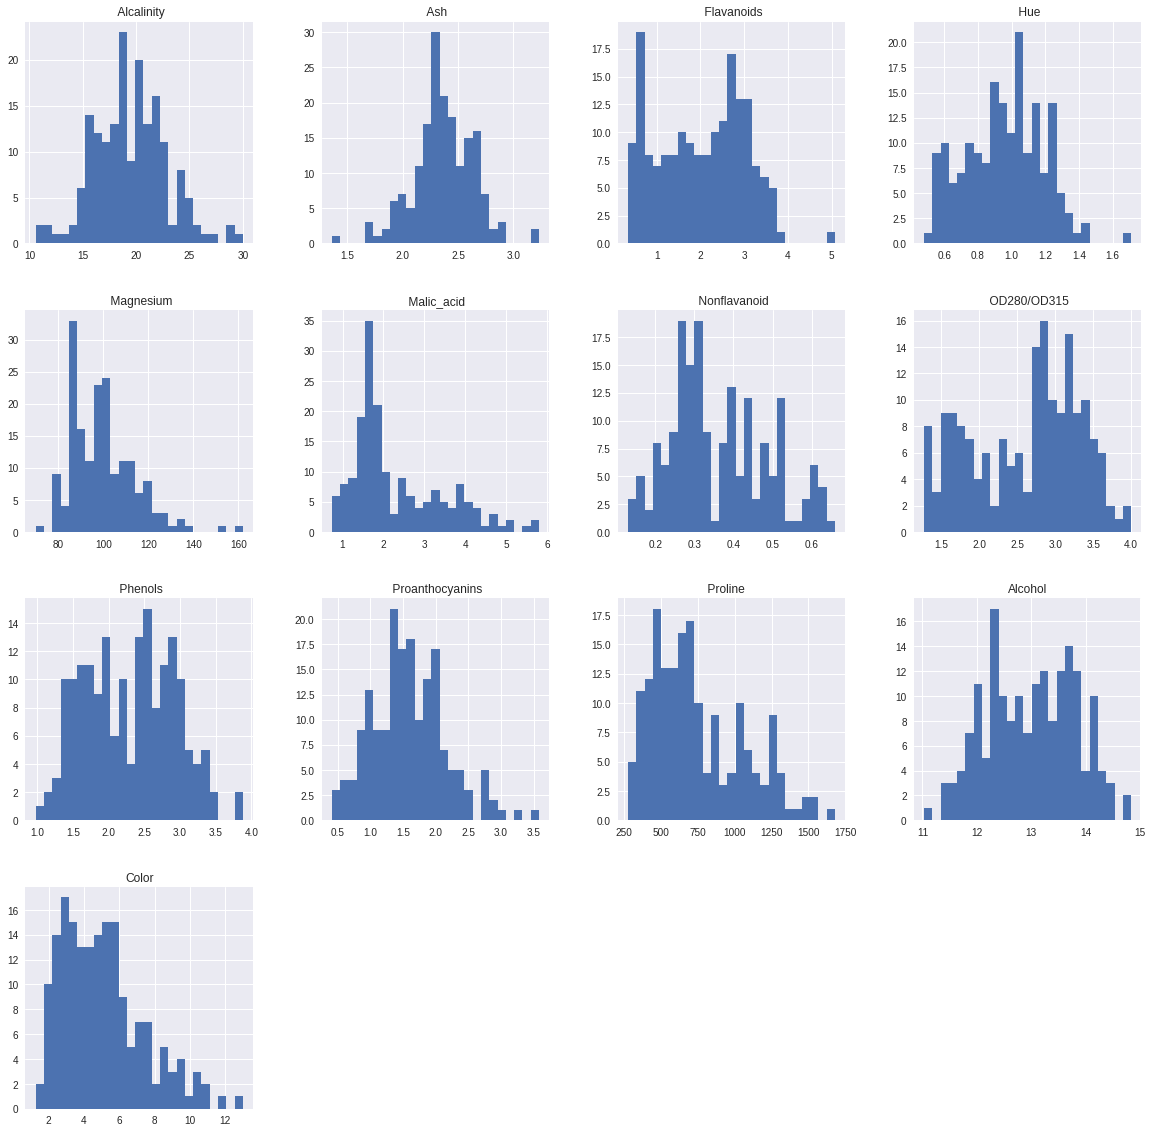

In [13]:
wine_df1.hist(bins=25,figsize=(20,20))



### 4. Usamos `scatter_matrix` y visualizamos todas las posibles combinaciones de características###
    * ¿Se encuentra algún par de características en el que se observan las clases bien separadas?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff86efd2400>,
      dtype=object)

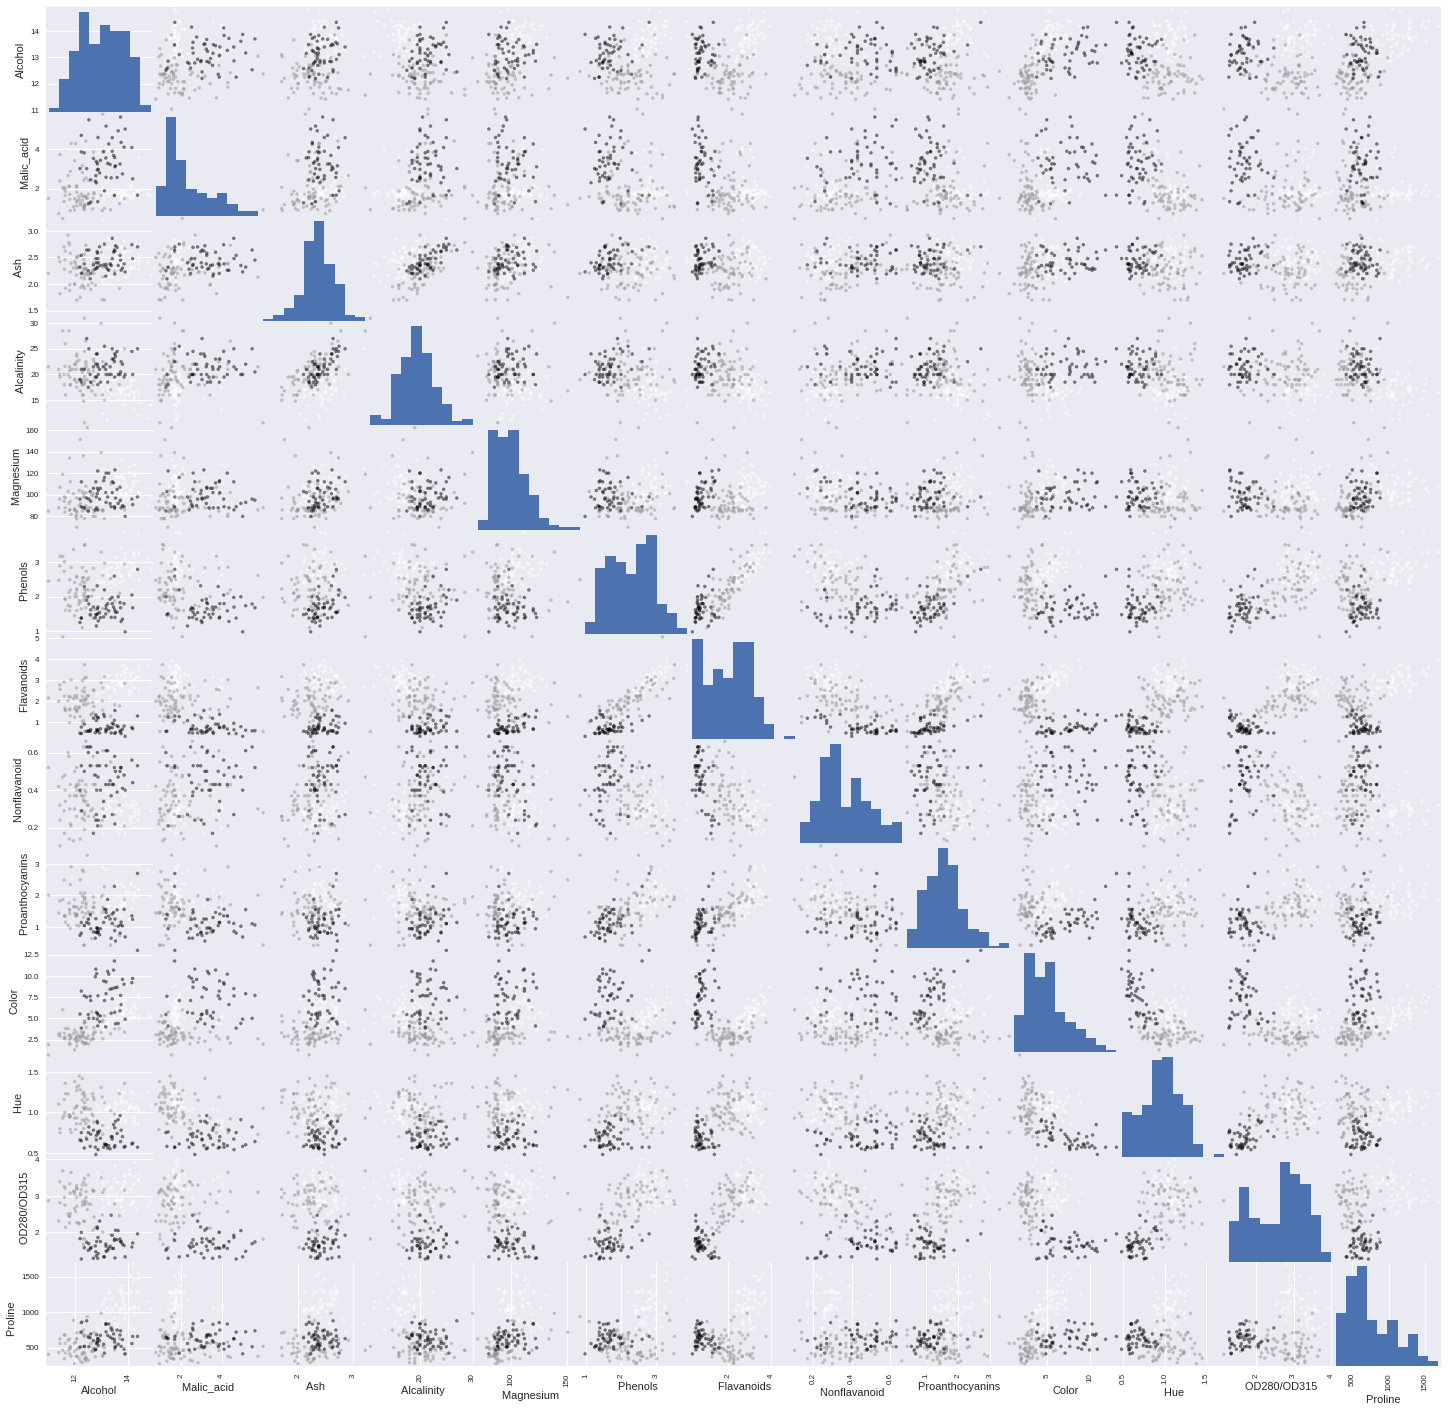

In [14]:

scatter_matrix(wine_df1, alpha=0.5,figsize=(25,25),c =class_array )

# Clasificación usando solo dos características y el esquema Multinomial:

### 5. Entrenamos un modelo LogisticRegression para categorizar el tipo de vino usando `Proline` contra `Flavonoids`.###

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
X = wine_df1.values[:,[6, 12]]
y= class_array.values

classifier = LogisticRegression()
classifier.fit(X, y);

### 6. Entrenamos otro modelo LogisticRegression para categorizar el tipo de vino usando `Alcalinity` contra `Malic Acid`.###

In [0]:
X2 = wine_df1.values[:,[1, 3]]
y2= class_array.values

classifier2 = LogisticRegression()
classifier2.fit(X2, y2);

### 7. Imprimimos la región de decisión de cada clasificador.###

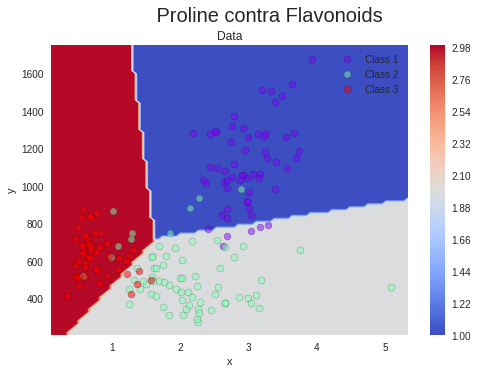

In [18]:
pl.figure(figsize = (8,16/3))    

plot_decision_region2(X, gen_pred_fun(classifier))
pl.suptitle(' Proline contra Flavonoids',fontsize=20)
plot_data(X, y)

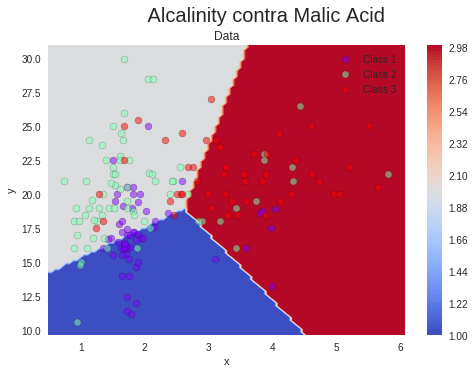

In [19]:
pl.figure(figsize = (8,16/3))    
plot_decision_region2(X2, gen_pred_fun(classifier2))
pl.suptitle(' Alcalinity contra Malic Acid',fontsize=20)
plot_data(X2, y2)

### 8. Generamos la matriz de confusión de cada clasificador.###

In [0]:
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

In [21]:
class_names=list(set(y))
y_pred = classifier.predict(X)
mat = confusion_matrix(y, y_pred)
list_cm(mat,class_names)

                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        54           5   0
Verdadero  2         4          61   6
           3         0           5  43


In [22]:
y2_pred = classifier2.predict(X2)
mat2 = confusion_matrix(y2, y2_pred)
list_cm(mat2,class_names)

                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        30          23   6
Verdadero  2         6          53  12
           3         1          16  31


### 9. Reportamos el accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro.###
    * ¿Cual modelo se desempeña mejor? ¿Por qué?

In [23]:
print('Accuracy classifier Proline vs Flavonoids: {}'.format(classifier.score(X, y)))
print('Accuracy classifier Alcalinity vs Malic Acid: {}'.format(classifier2.score(X2, y2)))
def error(matrix):
  TP = 0
  FP = 0
  FN = 0

  for i in range(len(matrix)): 
    for j in range(len(matrix)): 
      if i==j:
         TP += matrix[i][j]
      if i>j:
         FP += matrix[i][j]

      if i<j:
         FN += matrix[i][j]
  t_error= (FP+FN)/(TP+FN+FP)

  return t_error

print("error classifier Proline vs Flavonoids: ",error(mat))
print("error classifier Alcalinity vs Malic Acid: ",error(mat2))



Accuracy classifier Proline vs Flavonoids: 0.8876404494382022
Accuracy classifier Alcalinity vs Malic Acid: 0.6404494382022472
error classifier Proline vs Flavonoids:  0.11235955056179775
error classifier Alcalinity vs Malic Acid:  0.3595505617977528


In [24]:
from sklearn.metrics import recall_score, f1_score
print ("Proline vs Flavonoids")

print('Recall macro: {}'.format(recall_score(y, y_pred, average='macro')))
print('Recall micro: {}'.format(recall_score(y, y_pred, average='micro')))
print('Recall pesada: {}'.format(recall_score(y, y_pred, average='weighted')))

print('F1 macro: {}'.format(f1_score(y, y_pred, average='macro')))
print('F1 micro: {}'.format(f1_score(y, y_pred, average='micro')))
print('F1 pesada: {}'.format(f1_score(y, y_pred, average='weighted')))


Proline vs Flavonoids
Recall macro: 0.8900808333996446
Recall micro: 0.8876404494382022
Recall pesada: 0.8876404494382022
F1 macro: 0.8896099302662392
F1 micro: 0.8876404494382022
F1 pesada: 0.8877429184970016


In [25]:
from sklearn.metrics import recall_score, f1_score
print ("Alcalinity vs Malic Acid")

print('Recall macro: {}'.format(recall_score(y2, y2_pred, average='macro')))
print('Recall micro: {}'.format(recall_score(y2, y2_pred, average='micro')))
print('Recall pesada: {}'.format(recall_score(y2, y2_pred, average='weighted')))

print('F1 macro: {}'.format(f1_score(y2, y2_pred, average='macro')))
print('F1 micro: {}'.format(f1_score(y2, y2_pred, average='micro')))
print('F1 pesada: {}'.format(f1_score(y2, y2_pred, average='weighted')))

Alcalinity vs Malic Acid
Recall macro: 0.6335955942813188
Recall micro: 0.6404494382022472
Recall pesada: 0.6404494382022472
F1 macro: 0.6381606687327387
F1 micro: 0.6404494382022472
F1 pesada: 0.6389168062485298


### la comparacion de Proline vs Flavonoids tiene un mejor resultado en la predicción, puesto que en la gráfica se observa una mayor correlación entre los vinos de la misma clase.

# Clasificación usando todas las características

### 10. Entrenamos un modelo LogisticRegression usando el esquema "*One vs All*".###

In [26]:
X3 = wine_df1.values
y3= class_array.values
#print(X3)
classifier_ovr = LogisticRegression(multi_class='ovr')
classifier_ovr.fit(X3, y3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### 11. Entrenamos un modelo LogisticRegression usando el esquema multinomial.###

In [27]:
classifier_multi = LogisticRegression(multi_class='multinomial',  solver='lbfgs');
classifier_multi.fit(X3, y3)

#pl.figure(figsize = (8,16/3))    
#plot_decision_region2(X3, gen_pred_fun(classifier_multi))
#plot_data(X3, y3)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### 12  Generamos la matriz de confusión de cada clasificador.###

In [28]:
y3_pred = classifier_ovr.predict(X3)
mat_ovr = confusion_matrix(y3, y3_pred)
list_cm(mat_ovr,class_names)

                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        57           2   0
Verdadero  2         0          69   2
           3         0           1  47


In [29]:
y4_pred = classifier_multi.predict(X3)
mat_multi = confusion_matrix(y3, y4_pred)
list_cm(mat_multi,class_names)

                 Valor    Predicho
---------  --  -------  ----------  --
           -         1           2   3
Valor      1        56           3   0
Verdadero  2         0          69   2
           3         0           1  47


### 13  Reportamos el accuracy, el error de clasificación, la precisión por clase, el recall por clase y el F1 score por clase.###
  * ¿Cual modelo se desempeña mejor? ¿Por qué? ¿Cual clase es más sencilla para el clasificador?

In [30]:
print('Accuracy  One vs All classifier: {}'.format(classifier_ovr.score(X3, y3)))
print('Accuracy Multinomial classifier : {}\n'.format(classifier_multi.score(X3, y3)))
print("error  One vs All classifier: ",error(mat_ovr))
print("error  Multinomial classifier: ",error(mat_multi),"\n")

from sklearn.metrics import precision_score
print("Precision One vs All classifier")
print('Orden de las etiquetas: {}'.format(class_names))
print('Precision por clase: {}\n'.format(precision_score(y3, y3_pred, average=None)))
print("Precision Multinomial classifier")
print('Orden de las etiquetas: {}'.format(class_names))
print('Precision por clase: {}'.format(precision_score(y3, y4_pred, average=None)))

Accuracy  One vs All classifier: 0.9719101123595506
Accuracy Multinomial classifier : 0.9662921348314607

error  One vs All classifier:  0.028089887640449437
error  Multinomial classifier:  0.033707865168539325 

Precision One vs All classifier
Orden de las etiquetas: [1, 2, 3]
Precision por clase: [1.         0.95833333 0.95918367]

Precision Multinomial classifier
Orden de las etiquetas: [1, 2, 3]
Precision por clase: [1.         0.94520548 0.95918367]


In [31]:
from sklearn.metrics import recall_score, f1_score
print ("One vs All")

print('Recall macro: {}'.format(recall_score(y3, y3_pred, average='macro')))
print('Recall micro: {}'.format(recall_score(y3, y3_pred, average='micro')))
print('Recall pesada: {}'.format(recall_score(y3, y3_pred, average='weighted')))

print('F1 macro: {}'.format(f1_score(y3, y3_pred, average='macro')))
print('F1 micro: {}'.format(f1_score(y3, y3_pred, average='micro')))
print('F1 pesada: {}'.format(f1_score(y3, y3_pred, average='weighted')))

One vs All
Recall macro: 0.9723664491658046
Recall micro: 0.9719101123595506
Recall pesada: 0.9719101123595506
F1 macro: 0.9722885835576913
F1 micro: 0.9719101123595506
F1 pesada: 0.9719983430095389


In [32]:
print ("Multinomial classifier ")
print('Recall macro: {}'.format(recall_score(y3, y4_pred, average='macro')))
print('Recall micro: {}'.format(recall_score(y3, y4_pred, average='micro')))
print('Recall pesada: {}'.format(recall_score(y3, y4_pred, average='weighted')))

print('F1 macro: {}'.format(f1_score(y3, y4_pred, average='macro')))
print('F1 micro: {}'.format(f1_score(y3, y4_pred, average='micro')))
print('F1 pesada: {}'.format(f1_score(y3, y4_pred, average='weighted')))

Multinomial classifier 
Recall macro: 0.9667167316516804
Recall micro: 0.9662921348314607
Recall pesada: 0.9662921348314607
F1 macro: 0.9671061805866826
F1 micro: 0.9662921348314607
F1 pesada: 0.9663932592663473


##Conclusión
###Se tuvo un mejor desempeño con el modelo one vs all, debido a errores de clasificacion en la clase 2 para el modelo multinomial. La clase 1 tuvo una puntuación perfecta en ambos modelos.





**Instrucciones de envío:**

Este notebook debe enviarse a través del siguiente [File Request](https://www.dropbox.com/request/M4GoStgQHPycQ5NwjQba)
antes de la medianoche de la fecha límite. El archivo debe nombrarse como 
`iis-practica1-unalusername1-unalusername2.ipynb`, donde `unalusername` es el nombre de usuario asignado por la universidad (incluya los nombres de usuario de todos los miembros del grupo).